In [159]:
import cv2
import json
import math
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import re

from pathlib import Path
from PIL import Image

%matplotlib inline

cwd = Path.cwd()
data_folder = Path(cwd, 'dataset-sample')
reg_data_folder = Path(cwd, 'reg-data')

In [160]:
LABEL_IMG_PATTERN = '.*\.(JPG|png)'
LABEL_MASK_PATTERN = '.*\.json'
MSI_IMG_PATTERN = '.*\.png'


class Sample:

    def __init__(self, data_folder, sample_info):
        self.data_folder = data_folder
        self.id = None
        self.sample_path = None
        self.references = None
        self.data = None
        self._init_sample_info(sample_info)

    def _init_sample_info(self, sample_info):
        self.id = sample_info.get('id')
        self.sample_path = Path(self.data_folder, self.id)
        self.references = sample_info.get('ref_runs')
        self.data = sample_info.get('data_runs')

    def __repr__(self):
        return f"Sample(id={self.id})"
    
    # Data Images
    def get_data_paths(self, with_cap=True):
        """Return list of key-value pairs of label image and run image paths.
        
        Return: [
            {
                'label_img_path': Path,
                'label_mask_path': Path,
                'run_img_paths': [Path, Path, ...]
            },
        ]
        """
        
        labelled_folder = self.data.get('capillary').get('included') if with_cap else self.data.get('capillary').get('excluded')
        labelled_img_path = Path(self.sample_path, 'Labelling data', 'Definitive segmentation', labelled_folder)
        if not labelled_img_path.exists():
            labelled_img_path = Path(self.sample_path, 'Labelling data', 'Definitive segmentations', labelled_folder)

        paths = []
        run_group = self.data.get('runs').keys()
        for group in run_group:
            group_path = Path(labelled_img_path, group)
            label_img_path = [x for x in group_path.iterdir() if re.match(LABEL_IMG_PATTERN, x.name)][0]
            label_mask_path = [x for x in group_path.iterdir() if re.match(LABEL_MASK_PATTERN, x.name)][0]

            run_ids = self.data.get('runs').get(group)
            for run_id in run_ids:
                run_path = Path(data_folder, self.id, run_id)
                run_img_paths = [x for x in run_path.iterdir() if re.match(MSI_IMG_PATTERN, x.name)]

                paths.append({
                    'label_img_path': label_img_path,
                    'label_mask_path': label_mask_path,
                    'run_img_paths': sorted(run_img_paths)
                })
        
        return paths

    # Reference Images
    def get_reference_paths(self):
        """Return list of key-value pairs of reference image paths.
        
        Return: {
            'orient': Path,
            'white': Path,
            'dark': Path
        }
        """
        
        paths = {}
        ref_imgs = self.references.keys()
        for ref_img in ref_imgs:
            run_ids = self.references.get(ref_img)
            run_paths = [Path(data_folder, self.id, run_id) for run_id in run_ids]
            run_img_paths = [x for x in run_paths[0].iterdir() if re.match(MSI_IMG_PATTERN, x.name)]

            paths[ref_img] = sorted(run_img_paths)
        
        return paths
    
    # Reference Images
    @property
    def orient_ref_path(self):
        return self.get_reference_paths().get('orient')

    @property
    def white_ref_path(self):
        return self.get_reference_paths().get('white')

    @property
    def dark_ref_path(self):
        return self.get_reference_paths().get('dark')


sample_infos = json.load(Path(data_folder, 'hs-info.json').open())
samples = [Sample(data_folder, sample_info) for sample_info in sample_infos.get('data')]

In [161]:
sample_1 = samples[0]
sample_1.get_reference_paths()['white'][:5]

[PosixPath('/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS001/Run02/image sample 440nm.png'),
 PosixPath('/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS001/Run02/image sample 450nm.png'),
 PosixPath('/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS001/Run02/image sample 460nm.png'),
 PosixPath('/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS001/Run02/image sample 470nm.png'),
 PosixPath('/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS001/Run02/image sample 480nm.png')]

/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS003/Labelling data/Definitive segmentation/HS003 - capillary included/Run 08-12/Patient_1  12-06-13.JPG
/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS003/Run09/image sample 560nm 1.png
56


(-0.5, 1279.5, 1023.5, -0.5)

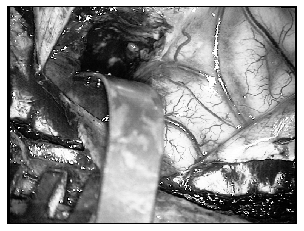

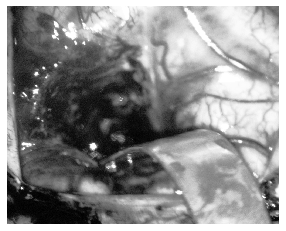

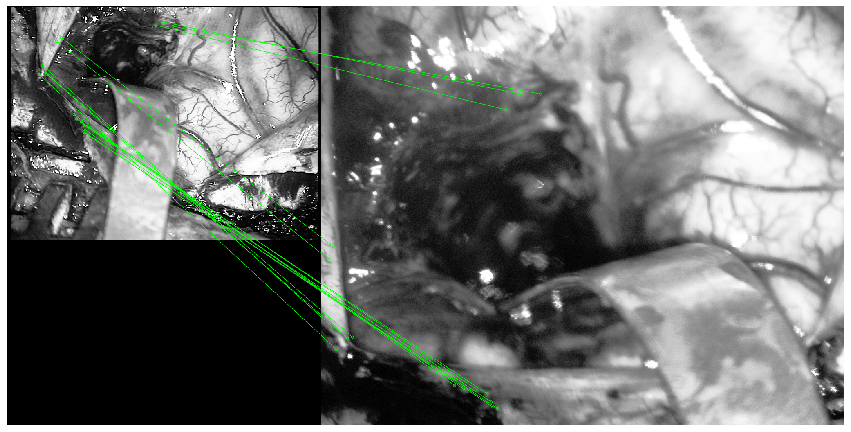

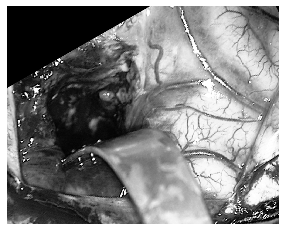

In [162]:
def get_560nm_img(img_paths):
    img_path = [x for x in img_paths if '560' in x.name][0]
    return img_path

test_sample = samples[2]
test_runs = test_sample.get_data_paths()[3]

source_img = test_runs.get('label_img_path')
print(source_img)
# source_img = np.asarray(Image.open(source_img).convert('L'))
source_img = np.asarray(Image.open(source_img).getchannel('G'))
source_img = cv2.flip(source_img, 0)
# source_img = cv2.rotate(source_img, cv2.ROTATE_90_CLOCKWISE)
source_img = cv2.equalizeHist(source_img)

target_img = get_560nm_img(test_runs.get('run_img_paths'))
print(target_img)
target_img = np.asarray(Image.open(target_img).convert('L'))
target_img = cv2.equalizeHist(target_img)


fig, ax = plt.subplots()
ax.imshow(source_img, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(target_img, 'gray')
ax.axis('off')

sift = cv2.SIFT_create()

# Find keypoints
kp_1, desc_1 = sift.detectAndCompute(source_img, None)
kp_2, desc_2 = sift.detectAndCompute(target_img, None)

# # brute force feature matching
# bf = cv2.BFMatcher()
# matches = bf.knnMatch(desc_1, desc_2, k=2)

# flann feature matching
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_1, desc_2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
print(len(good))

MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(source_img, kp_1, target_img, kp_2, good, None, **draw_params)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(img3, 'gray')
ax.axis('off')

tgt_warped = cv2.warpPerspective(source_img, M, (target_img.shape[1], target_img.shape[0]))
fig, ax = plt.subplots()
ax.imshow(tgt_warped, 'gray')
ax.axis('off')

(-0.5, 1279.5, 1023.5, -0.5)

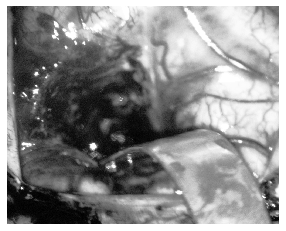

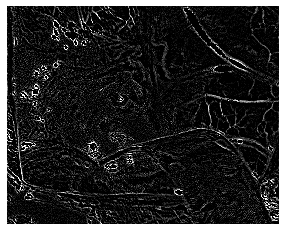

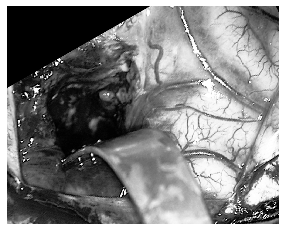

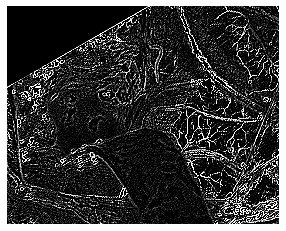

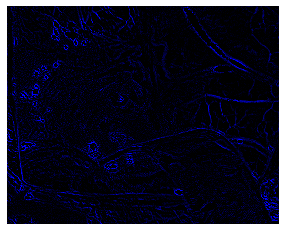

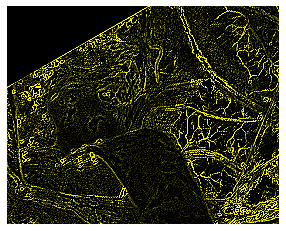

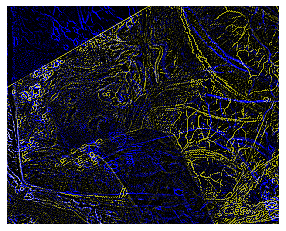

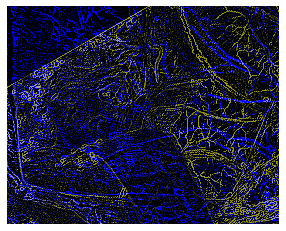

In [163]:
# MIN_THRESH = 5
# MAX_THRESH = 50

img_a = target_img.copy()
img_a_temp = np.zeros(img_a.shape, dtype=np.uint8)
img_a = cv2.equalizeHist(img_a)
img_a = cv2.normalize(img_a, img_a_temp, 0, 255, cv2.NORM_MINMAX)
img_a_blur = cv2.GaussianBlur(img_a, (5, 5), 2)
# img_a_edge = cv2.Sobel(img_a_blur, cv2.CV_8U, 1, 1, ksize=5)
# img_a_edge = cv2.Canny(img_a_blur, MIN_THRESH, MAX_THRESH)
img_a_edge = cv2.Laplacian(img_a_blur, cv2.CV_8U, ksize=5)

img_b = tgt_warped.copy()
img_b_temp = np.zeros(img_b.shape, dtype=np.uint8)
img_b = cv2.equalizeHist(img_b)
img_b_blur = cv2.GaussianBlur(img_b, (5, 5), 2)
# img_b_edge = cv2.Sobel(img_b_blur, cv2.CV_8U, 1, 1, ksize=5)
# img_b_edge = cv2.Canny(img_b_blur, MIN_THRESH, MAX_THRESH)
img_b_edge = cv2.Laplacian(img_b_blur, cv2.CV_8U, ksize=5)

fig, ax = plt.subplots()
ax.imshow(img_a, 'gray')
ax.axis('off')
fig, ax = plt.subplots()
ax.imshow(img_a_edge, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_b, 'gray')
ax.axis('off')
fig, ax = plt.subplots()
ax.imshow(img_b_edge, 'gray')
ax.axis('off')

# BGR
# comb_img = np.zeros((img_a.shape[0], img_a.shape[1], 3), dtype=np.uint8)
# comb_img[:, :, 0] = img_a # red
# comb_img[:, :, 1] = img_a # green (red+green = yellow)
# comb_img[:, :, 2] = img_b # blue

# fig, ax = plt.subplots()
# ax.imshow(comb_img)
# ax.axis('off')

# create a yellow mask of img_a
# img_a_y = np.zeros(img_a.shape, dtype=np.uint8)
# img_a_y[img_a > 0] = [0, img_a, img_a]
img_a_y = np.zeros((*img_a_edge.shape, 3), dtype=np.uint8)
img_a_y[:, :, 0] = 0
img_a_y[:, :, 1] = 0
img_a_y[:, :, 2] = img_a_edge

# create a blue mask of img_b
# img_b_b = np.zeros(img_b.shape, dtype=np.uint8)
# img_b_b[img_b > 0] = [img_b, 0, 0]
img_b_b = np.zeros((*img_b_edge.shape, 3), dtype=np.uint8)
img_b_b[:, :, 0] = img_b_edge
img_b_b[:, :, 1] = img_b_edge
img_b_b[:, :, 2] = 0

# combine the masks to create the full color mask
# img_ab = cv2.addWeighted(img_a_y, 1, img_b_b, 1, 0)
img_ab = cv2.addWeighted(img_a_y, 2, img_b_b, 0.7, 0)
img_ab2 = cv2.addWeighted(img_a_y, 3, img_b_b, 0.6, 0)

fig, ax = plt.subplots()
ax.imshow(img_a_y)
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_b_b)
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_ab)
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_ab2)
ax.axis('off')


(-0.5, 1279.5, 1023.5, -0.5)

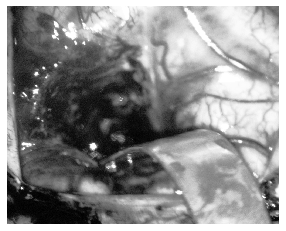

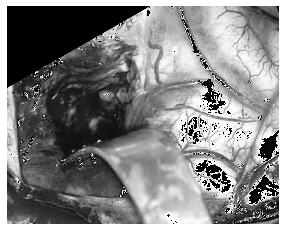

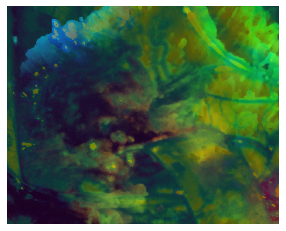

In [164]:
img_a = target_img.copy()
img_a_temp = np.zeros(img_a.shape, dtype=np.uint8)
img_a = cv2.normalize(img_a, img_a_temp, 0, 255, cv2.NORM_MINMAX)
img_a_mean = np.mean(img_a)

img_b = tgt_warped.copy()
img_b_temp = np.zeros(img_b.shape, dtype=np.uint8)
img_b = cv2.normalize(img_b, img_b_temp, 0, 255, cv2.NORM_MINMAX)
img_b_mean = np.mean(img_b)

## add the difference between the two images to the target image
img_b[img_b > 0] = img_b[img_b > 0] + (img_a_mean - img_b_mean)
img_b[img_b > 255] = 255


fig, ax = plt.subplots()
ax.imshow(img_a, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_b, 'gray')
ax.axis('off')


hsv = np.zeros((img_a.shape[0], img_a.shape[1], 3), dtype=np.uint8)
hsv[..., 1] = 255

flow = cv2.calcOpticalFlowFarneback(img_a, img_b, None, 0.5, 5, 11, 5, 5, 1.1, 0)
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# bgr = cv2.absdiff(img_a, img_b)

fig, ax = plt.subplots()
ax.imshow(img_a)
ax.imshow(bgr, alpha=0.6)
ax.axis('off')

In [165]:
from skimage.exposure import cumulative_distribution
import matplotlib.pylab as plt
import numpy as np

def cdf(im):
    '''
    computes the CDF of an image im as 2D numpy ndarray
    '''
    c, b = cumulative_distribution(im) 
    # pad the beginning and ending pixels and their CDF values
    c = np.insert(c, 0, [0]*b[0])
    c = np.append(c, [1]*(255-b[-1]))
    return c

def hist_matching(c, c_t, im):
    '''
    c: CDF of input image computed with the function cdf()
    c_t: CDF of template image computed with the function cdf()
    im: input image as 2D numpy ndarray
    returns the modified pixel values
    ''' 
    pixels = np.arange(256)
    # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of   
    # the template image at the corresponding pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
    new_pixels = np.interp(c, c_t, pixels) 
    im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
    return im

(-0.5, 1279.5, 1023.5, -0.5)

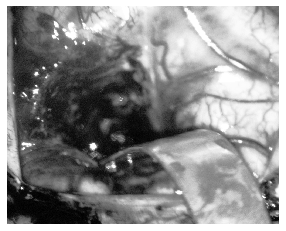

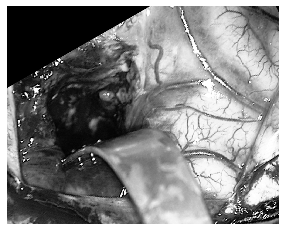

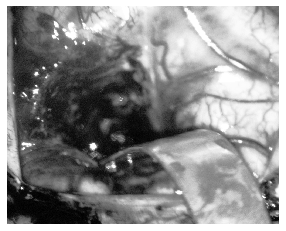

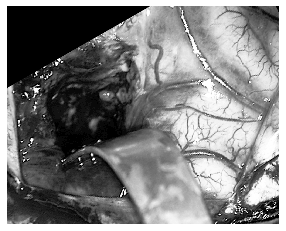

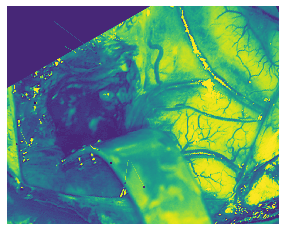

In [166]:
img_a = target_img.copy()
# img_a = cv2.equalizeHist(img_a)
img_a_cdf = cdf(img_a)

img_b = tgt_warped.copy()
# img_b = cv2.equalizeHist(img_b)
img_b_cdf = cdf(img_b)

fig, ax = plt.subplots()
ax.imshow(img_a, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_b, 'gray')
ax.axis('off')


img_b = hist_matching(img_b_cdf, img_a_cdf, img_b)

fig, ax = plt.subplots()
ax.imshow(img_a, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_b, 'gray')
ax.axis('off')


# LK optical flow
feature_params = dict(maxCorners = 100, qualityLevel = 0.3, minDistance = 7, blockSize = 7)
# Parameters for lucas kanade optical flow
lk_params = dict(winSize  = (15, 15), maxLevel = 2, criteria=(cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, 10, 0.03))

color = np.random.randint(0, 255, (100, 3))
p0 = cv2.goodFeaturesToTrack(img_a, mask = None, **feature_params)
mask = np.zeros_like(img_a)

# calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(img_a, img_b, p0, None, **lk_params)
# Select good points
if p1 is not None:
    good_new = p1[st==1]
    good_old = p0[st==1]
# draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
    img_b = cv2.circle(img_b, (int(a), int(b)), 5, color[i].tolist(), -1)

img_new = cv2.add(img_b, mask)

fig, ax = plt.subplots()
ax.imshow(img_new)
ax.axis('off')

In [167]:
samples

[Sample(id=HS001),
 Sample(id=HS002),
 Sample(id=HS003),
 Sample(id=HS004),
 Sample(id=HS005),
 Sample(id=HS006)]

In [168]:
# import time
# for i in range(1000):
#     time.sleep(0.01)
#     print(f'\r{i}', end="")